# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [251]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import math

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /content/drive/My Drive/cs445_projects/proj2/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj2/samples: No such file or directory


In [252]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [4]:
def quilt_random(sample, out_size, patch_size):
        
    out_img = np.empty(shape=(out_size,out_size, 3))
    out_img.fill(0)
    in_r, in_c = len(sample), len(sample[0])
    reps = math.floor(out_size/patch_size)
    r_max = math.floor(in_r/patch_size)
    c_max = math.floor(in_c/patch_size)
    # copies a patch of size ps x ps from (in_r, in_c) to (out_r, out_c)
    for idx in range(reps):
        for jdx in range(reps):
            r = (int)(random()*r_max)*patch_size
            c = (int)(random()*c_max)*patch_size
            out_r= idx *patch_size
            out_c= jdx*patch_size
            #print(r,c, out_c, out_r)

            out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), :] = sample[r:(r+patch_size), c:(c+patch_size),:]
    return np.int_(out_img)
    """

    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """



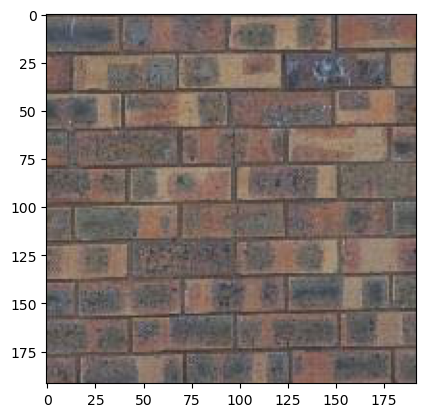

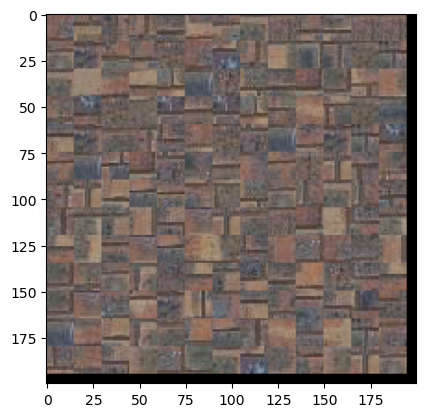

In [22]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [294]:

def ssd_patch(T, M, I, tol):
    Ishape =I.shape
    sum_costs = np.empty(shape=(Ishape[0],Ishape[1]))
    sum_costs.fill(0)
    for chan in range(3):
        ssd_cost = ((M[:,:,chan]*T[:,:,chan])**2).sum() - 2 * cv2.filter2D(I[:,:,chan], ddepth=-1, kernel = M[:,:,chan]*T[:,:,chan]) + cv2.filter2D(I[:,:,chan] ** 2, ddepth=-1, kernel=M[:,:,chan])
        sum_costs+=ssd_cost
    for idx in range(len(sum_costs)):
        for jdx in range(len(sum_costs[idx])):
            if (idx-(patch_size/2))<0 or (idx+(patch_size/2))>=len(I) or (jdx-(patch_size/2))<0 or (jdx+(patch_size/2))>=len(I[0]):
                sum_costs[idx][jdx]=sys.float_info.max
    return choose_sample(sum_costs, tol)

def choose_sample(costs, tol):
    idx = (int)(random()*(tol))
    ind = np.argsort(costs, None)
    in_r, in_c = np.unravel_index(ind[idx], costs.shape)
    return (in_r, in_c)


def quilt_simple(sample, out_size, patch_size, overlap, tol):

    out_img = np.empty(shape=(out_size,out_size, 3))
    out_img.fill(0)
    in_r, in_c = len(sample), len(sample[0])
    reps = 1+math.floor((out_size- patch_size)/(patch_size-overlap))
    r_max = math.floor(in_r/patch_size)
    c_max = math.floor(in_c/patch_size)
    # copies a patch of size ps x ps from (in_r, in_c) to (out_r, out_c)
    for idx in range(reps):
        for jdx in range(reps):
            if idx ==0 and jdx ==0:
                r = (int)(random()*r_max)*patch_size
                c = (int)(random()*c_max)*patch_size
                out_img[0:(patch_size), 0:(patch_size), :] = sample[r:(r+patch_size), c:(c+patch_size),:]
            else:
                out_r=idx*(patch_size-overlap)
                out_c=jdx*(patch_size-overlap)
                x = out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size),:]
                template =np.copy(x)
                mask =np.copy(x)
                mask[mask != 0] = 1 
                center = ssd_patch(template, mask, np.float64(sample), tol)
                mask2=np.copy(mask)
                #invert mask
                mask2[mask2 == 1] = 3 
                mask2[mask2 == 0] = 1 
                mask2[mask2 == 3] = 0
                out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), :] += (sample[int(center[0]-(patch_size/2)): int(center[0]+(patch_size/2)), int(center[1]-(patch_size/2)):int(center[1]+(patch_size/2)),:]*mask2)
    
    return np.int_(out_img)
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


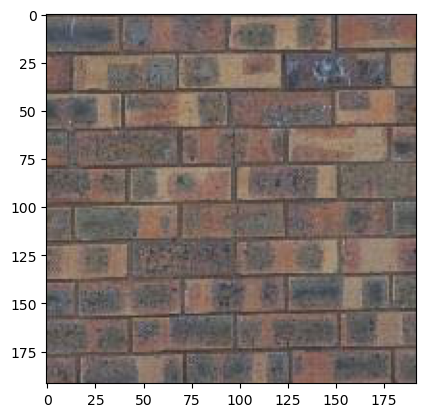

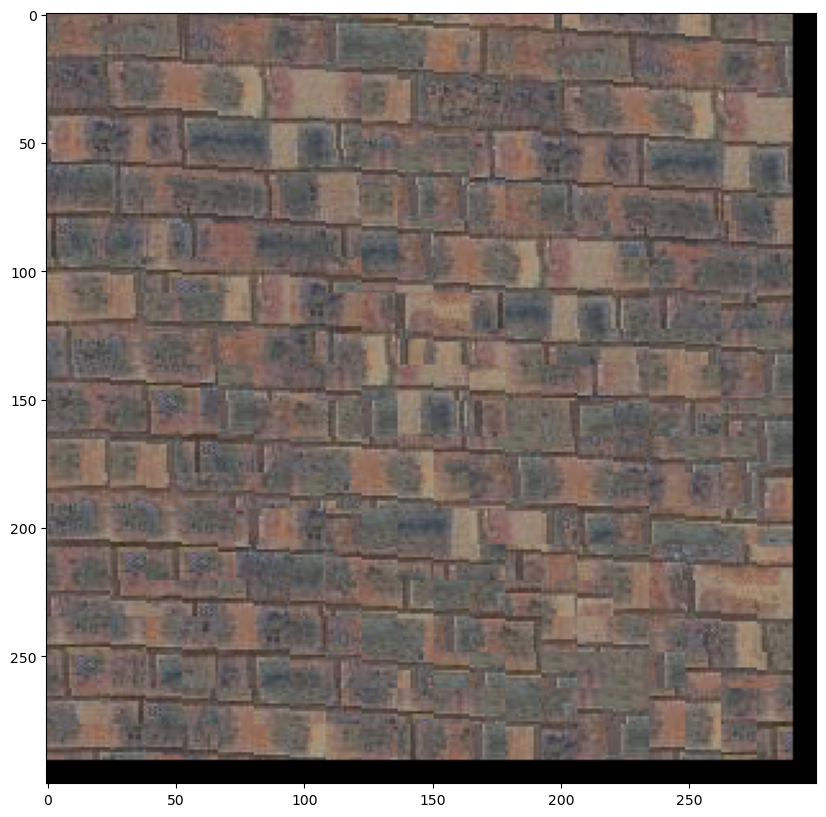

In [295]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [378]:
def computeErrPatch(mask, horSeam, verSeam, patch_size, output_patch, sampled_patch):
    err_patch = np.empty(shape=(patch_size,patch_size))
    err_patch.fill(0)
    for chan in range(3):
        ssd_cost = ((mask[:,:,chan]*output_patch[:,:,chan])**2).sum() - 2 * cv2.filter2D(sampled_patch[:,:,chan], ddepth=-1, kernel = mask[:,:,chan]*output_patch[:,:,chan]) + cv2.filter2D(sampled_patch[:,:,chan] ** 2, ddepth=-1, kernel=mask[:,:,chan])
        #ssd_cost = np.sum((np.array(output_patch, dtype=np.float64) - np.array(sampled_patch, dtype=np.float64))**2)
        #ssd_cost = ((output_patch[:,:,chan])**2).sum() - 2 * cv2.filter2D( np.float64(sampled_patch[:,:,chan]), ddepth=-1, kernel = output_patch[:,:,chan]) + cv2.filter2D( np.float64(sampled_patch[:,:,chan]) ** 2, ddepth=-1, kernel=output_patch[:,:,chan])
        err_patch+=ssd_cost
    '''for idx in range(len(err_patch)):
        for jdx in range(len(err_patch[idx])):
            if mask[idx][jdx][0]==0 and mask[idx][jdx][1]==0 and mask[idx][jdx][2]==0:
                err_patch[idx][jdx]=100000000'''
    if horSeam and not verSeam:
        out_mask = cut(err_patch.T).T
    elif verSeam and not horSeam:
        out_mask = cut(err_patch)
    elif verSeam and horSeam:
        out_mask = np.logical_and(cut(err_patch), (cut(err_patch.T).T))
    return out_mask


def quilt_cut(sample, out_size, patch_size, overlap, tol):

    out_img = np.empty(shape=(out_size,out_size, 3))
    out_img.fill(0)
    in_r, in_c = len(sample), len(sample[0])
    reps = 1+math.floor((out_size- patch_size)/(patch_size-overlap))
    r_max = math.floor(in_r/patch_size)
    c_max = math.floor(in_c/patch_size)
    # copies a patch of size ps x ps from (in_r, in_c) to (out_r, out_c)
    for idx in range(reps):
        for jdx in range(reps):
            if idx ==0 and jdx ==0:
                r = (int)(random()*r_max)*patch_size
                c = (int)(random()*c_max)*patch_size
                out_img[0:(patch_size), 0:(patch_size), :] = sample[r:(r+patch_size), c:(c+patch_size),:]
            else:
                out_r=idx*(patch_size-overlap)
                out_c=jdx*(patch_size-overlap)
                x = out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size),:]
                template =np.copy(x)
                mask =np.copy(x)
                mask[mask != 0] = 1 
                center = ssd_patch(template, mask, np.float32(sample), tol)                
                horSeam=True
                verSeam =True
                if idx ==0:
                    horSeam=False
                if jdx ==0:
                    verSeam=False
                out_mask = computeErrPatch(mask, horSeam, verSeam, patch_size, out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), :],  np.float32(sample[int(center[0]-(patch_size/2)): int(center[0]+(patch_size/2)), int(center[1]-(patch_size/2)):int(center[1]+(patch_size/2)),:]) )
                
               # plt.figure(figsize=(5,5))
               # plt.imshow(out_mask)
                for chan in range(3):
                    out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), chan] *= out_mask
                #invert mask
                out_mask[out_mask == 1] = 3 
                out_mask[out_mask == 0] = 1 
                out_mask[out_mask == 3] = 0
                for chan in range(3):
                    out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), chan]+= (np.float32(sample[int(center[0]-(patch_size/2)): int(center[0]+(patch_size/2)), int(center[1]-(patch_size/2)):int(center[1]+(patch_size/2)), chan])*np.float32(out_mask))
    
    return np.int_(out_img)
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


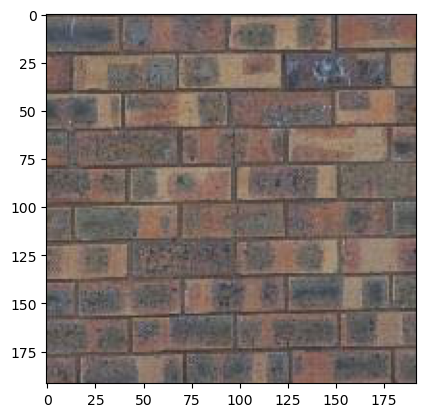

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


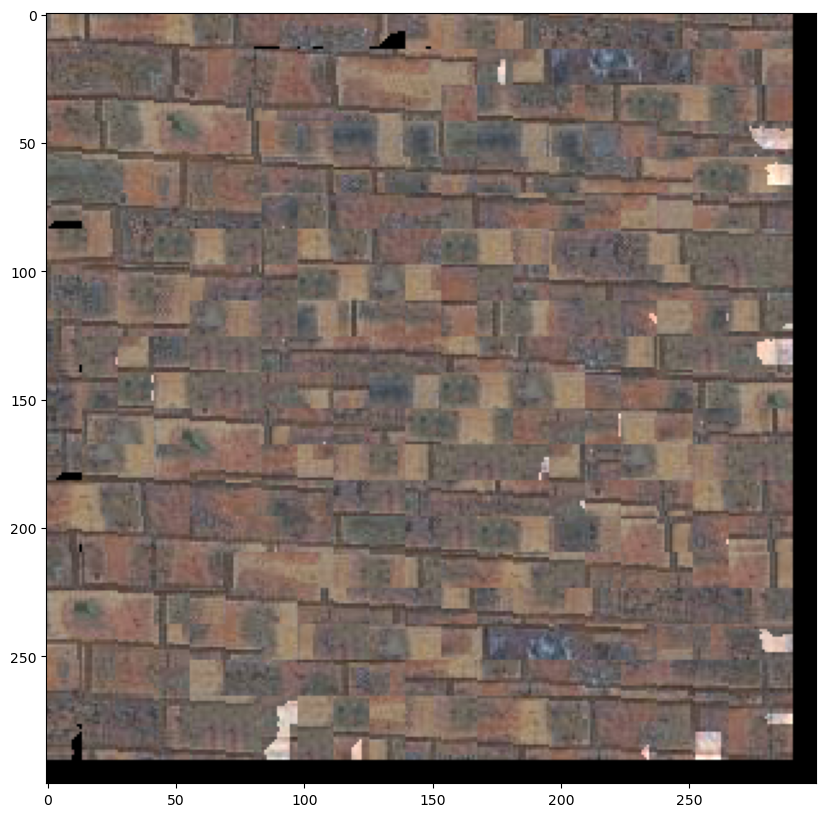

In [379]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):


    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).